# Diabetes Detection Model
This model creates a 1D CNN-based diabetes detction moel, based on many parameters and achieves a 75%+ Accuracy, using Adam optimizer and 75% on svm.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import pickle

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names = columns)
## Handling missing values by replacing zeros with median
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[zero_columns] = data[zero_columns].replace(0, np.nan)
data.fillna(data.median(), inplace = True)

In [3]:
X = data.drop(columns = ['Outcome']).values
Y = data['Outcome'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Z_train = X_train
Z_test = X_test

## Reshaping for 1D CNN layers
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(filters=256, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# Using a more sophisticated optimizer with learning rate scheduling
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

# Adding early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Train the model with more epochs and the early stopping callback
history = model.fit(X_train, Y_train, 
                    epochs=200, 
                    batch_size=32, 
                    validation_data=(X_test, Y_test), 
                    verbose=2,
                    callbacks=[early_stopping])

Epoch 1/200
22/22 - 15s - 689ms/step - accuracy: 0.5123 - auc: 0.5227 - loss: 0.9497 - val_accuracy: 0.6494 - val_auc: 0.5567 - val_loss: 0.6799
Epoch 2/200
22/22 - 1s - 51ms/step - accuracy: 0.5702 - auc: 0.5800 - loss: 0.8875 - val_accuracy: 0.6494 - val_auc: 0.7444 - val_loss: 0.6569
Epoch 3/200
22/22 - 1s - 48ms/step - accuracy: 0.6237 - auc: 0.6450 - loss: 0.7905 - val_accuracy: 0.6494 - val_auc: 0.7481 - val_loss: 0.6328
Epoch 4/200
22/22 - 1s - 52ms/step - accuracy: 0.6064 - auc: 0.6553 - loss: 0.7665 - val_accuracy: 0.6494 - val_auc: 0.7711 - val_loss: 0.6241
Epoch 5/200
22/22 - 1s - 50ms/step - accuracy: 0.6035 - auc: 0.6267 - loss: 0.8064 - val_accuracy: 0.6494 - val_auc: 0.7919 - val_loss: 0.6118
Epoch 6/200
22/22 - 1s - 51ms/step - accuracy: 0.6339 - auc: 0.6606 - loss: 0.7462 - val_accuracy: 0.6753 - val_auc: 0.7789 - val_loss: 0.6178
Epoch 7/200
22/22 - 1s - 52ms/step - accuracy: 0.6440 - auc: 0.6831 - loss: 0.6990 - val_accuracy: 0.6883 - val_auc: 0.8007 - val_loss: 0.62

In [7]:
## Predictions
Y_pred_cnn = (model.predict(X_test) >= 0.5).astype(int)
## Accuracy and Confusion Matrix
accuracy_cnn = accuracy_score(Y_test, Y_pred_cnn)
conf_matrix_cnn = confusion_matrix(Y_test, Y_pred_cnn)
print(f"CNN model Accuracy: {accuracy_cnn * 100:.2f}%")
print("\nConfusion Matrix (CNN):\n", conf_matrix_cnn)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
CNN model Accuracy: 76.62%

Confusion Matrix (CNN):
 [[38 12]
 [ 6 21]]


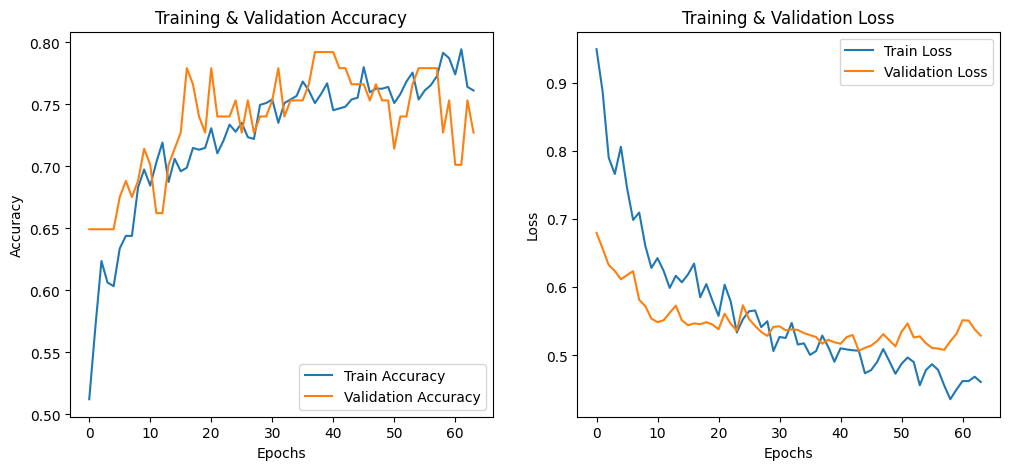

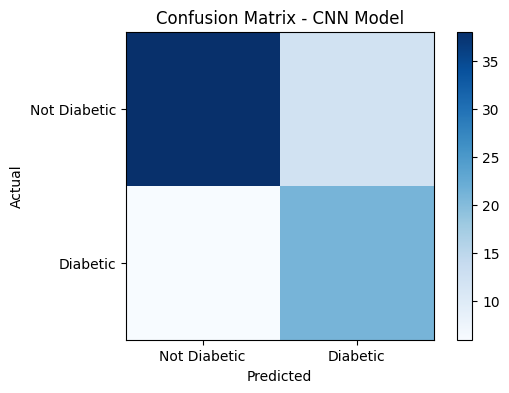

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()


## Plotting Confusion Matrix
plt.figure(figsize = (6, 4))
plt.imshow(conf_matrix_cnn, cmap="Blues", interpolation="nearest")

plt.colorbar()
plt.xticks([0, 1], ["Not Diabetic", "Diabetic"])
plt.yticks([0, 1], ["Not Diabetic", "Diabetic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Model")
plt.show()

In [9]:
svm_model = SVC(kernel = 'rbf', C=1, gamma = 'scale')
svm_model.fit(Z_train, Y_train)
Y_pred_svm = svm_model.predict(Z_test)

In [10]:
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
conf_matrix_svm = confusion_matrix(Y_test, Y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm * 100:.2f}%")
print("\nConfusion Matrix (SVM):\n", conf_matrix_svm)

SVM Model Accuracy: 74.03%

Confusion Matrix (SVM):
 [[41  9]
 [11 16]]


In [12]:
def predict_new_cases():
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
               'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    
    while True:
        print("\nEnter patient details (or type 'quit' to exit):")
        values = []
        valid_input = True
        
        for col in columns:
            while True:
                value = input(f"{col}: ")
                if value.lower() == 'quit':
                    return
                
                try:
                    value = float(value)
                    if col == 'Pregnancies' and (value < 0 or value > 20):
                        print("Pregnancies should be between 0-20")
                        continue
                    elif col == 'Glucose' and (value < 0 or value > 200):
                        print("Glucose should be between 0-200")
                        continue
                    elif col == 'BloodPressure' and (value < 0 or value > 122):
                        print("BloodPressure should be between 0-122")
                        continue
                    elif col == 'SkinThickness' and (value < 0 or value > 99):
                        print("SkinThickness should be between 0-99")
                        continue
                    elif col == 'Insulin' and (value < 0 or value > 846):
                        print("Insulin should be between 0-846")
                        continue
                    elif col == 'BMI' and (value < 0 or value > 67.1):
                        print("BMI should be between 0-67.1")
                        continue
                    elif col == 'DiabetesPedigreeFunction' and (value < 0.078 or value > 2.42):
                        print("DiabetesPedigreeFunction should be between 0.078-2.42")
                        continue
                    elif col == 'Age' and (value < 21 or value > 81):
                        print("Age should be between 21-81")
                        continue
                    break
                except ValueError:
                    print("Please enter a valid number")
                    continue
            
            values.append(value)
        
        # Create dataframe and preprocess
        new_data = pd.DataFrame([values], columns=columns)
        new_data_scaled = scaler.transform(new_data)
        new_data_scaled = new_data_scaled.reshape(new_data_scaled.shape[0], new_data_scaled.shape[1], 1)
        
        # Make prediction
        prediction = model.predict(new_data_scaled)
        probability = prediction[0][0]
        result = "Diabetic" if probability > 0.5 else "Not Diabetic"
        
        print(f"\nPrediction: {result} (Probability: {probability:.2%})")
        
        another = input("\nPredict another patient? (yes/no): ")
        if another.lower() != 'yes':
            break

# Run the prediction function
predict_new_cases()
with open("Diabetes_CNN_Detection.pkl", "wb") as f:
    pickle.dump(model, f)
model.save("diabetes_model.h5")
joblib.dump(scaler, "scaler.save")


Enter patient details (or type 'quit' to exit):


Pregnancies:  5
Glucose:  57
BloodPressure:  97
SkinThickness:  88
Insulin:  74
BMI:  40
DiabetesPedigreeFunction:  0.9
Age:  25


C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step

Prediction: Not Diabetic (Probability: 25.28%)



Predict another patient? (yes/no):  no


['scaler.save']